In [40]:
import re
import string
import eli5
import joblib
import wordcloud
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from colour import Color
from collections import Counter

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import minmax_scale, scale
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import StratifiedKFold

from mlgear.cv import run_cv_model
from mlgear.models import runLR
from mlgear.utils import show

In [2]:
data = pd.read_csv('~/Downloads/more data export experiences.csv')
data.columns = ['engagement', 'engagement_changed', 'why_engagement_changed', 'NPS', 'details',
       'barrier_EA_too_demanding', 'barrier_limited_advice', 'barrier_no_jobs', 'barrier_jobs_too_hard',
       'barrier_idk_donate', 'barrier_idk_movement_build', 'barrier_no_mentor', 'barrier_no_diverse',
       'barrier_unwelcoming', 'barrier_elitist', 'barrier_no_social', 'barrier_no_friends', 'barrier_no_group',
       'barrier_no_passion', 'no_barrier', 'barrier_details', 'rentention_gwwc', 'retention_givewell',
       'retention_ea_funds', 'retention_donating', 'retention_project', 'retention_eag', 'retention_eagx',
       'retention_group', 'retention_group_leader', 'retention_ea_friends', 'retention_ea_forum', 'retention_ssc',
       'retention_lw', 'retention_ea_fb', 'retention_ea_discord', 'retention_future_perfect', 'retention_details']
data.fillna(0, inplace=True)
data['engagement'] = (data['engagement'].apply(lambda s: 0 if s == 'Response' else s)
                                        .apply(lambda s: str(s).split(' ')[0]
                                               .replace('(', '').replace(')', ''))
                                        .astype(int))
data['engagement_changed'] = (data['engagement_changed'].apply(lambda s: 0 if s == 'Response' else s)
                                                        .apply(lambda s: str(s).split(' ')[0]
                                                               .replace('(', '').replace(')', ''))
                                                        .astype(int) - 4)

for barrier in [c for c in data.columns if 'barrier' in c and 'detail' not in c]:
    data[barrier] = data[barrier].apply(lambda s: 0 if s == 0 else 1)

for retention in [c for c in data.columns if 'retention' in c and 'detail' not in c]:
    data[retention] = data[retention].apply(lambda s: 0 if s == 0 else 1)

data = data.iloc[1:]
show(data)

      engagement  engagement_changed  \
1              3                   0   
2              2                   0   
3              2                  -4   
4              5                   0   
5              5                   3   
...          ...                 ...   
2510           3                   3   
2511           3                   1   
2512           3                   0   
2513           5                  -4   
2514           5                   2   

                                 why_engagement_changed NPS  \
1                                                     0  -8   
2                                                     0  -7   
3                                                     0   0   
4                                                     0  -7   
5     More engaged in the events/conferences related...  -9   
...                                                 ...  ..   
2510        Started to understand and to share the idea  -8   
2511           

In [3]:
for c in data.dtypes[data.dtypes == int].keys():
    print('###')
    print(c)
    print(data[c].value_counts())

###
engagement
3    733
4    470
5    456
2    424
0    388
1     43
Name: engagement, dtype: int64
###
engagement_changed
 0    739
-4    579
 1    304
 3    270
 2    267
-1    238
-2    101
-3     16
Name: engagement_changed, dtype: int64
###
barrier_EA_too_demanding
0    2292
1     222
Name: barrier_EA_too_demanding, dtype: int64
###
barrier_limited_advice
0    2258
1     256
Name: barrier_limited_advice, dtype: int64
###
barrier_no_jobs
0    2000
1     514
Name: barrier_no_jobs, dtype: int64
###
barrier_jobs_too_hard
0    2104
1     410
Name: barrier_jobs_too_hard, dtype: int64
###
barrier_idk_donate
0    2417
1      97
Name: barrier_idk_donate, dtype: int64
###
barrier_idk_movement_build
0    2177
1     337
Name: barrier_idk_movement_build, dtype: int64
###
barrier_no_mentor
0    2240
1     274
Name: barrier_no_mentor, dtype: int64
###
barrier_no_diverse
0    2309
1     205
Name: barrier_no_diverse, dtype: int64
###
barrier_unwelcoming
0    2362
1     152
Name: barrier_unwelcomin

In [39]:
random.choice([d for d in data['details'].values if d != 0])

'Thank you very much! I love the community!'

In [5]:
exclude = set(string.punctuation)

def clean_text(txt):
    txt = txt.lower()    
    txt = ''.join(ch for ch in txt if ch not in exclude)
    return txt

custom_stop_words = stop_words + ['i', 'ea']
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.6,
    max_features=300,
    stop_words=custom_stop_words
)
tfidf_text = tfidf.fit_transform([clean_text(d) for d in data['details'].values if d != 0])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


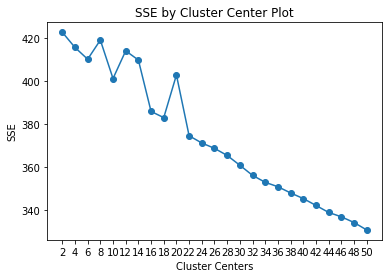

In [6]:
# Adapted from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)

    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    return plt, sse

plt, sse = find_optimal_clusters(tfidf_text, 50)
plt.show()

In [17]:
def cluster_counts(clusters):
    unique, counts = np.unique(clusters, return_counts=True)
    cc = dict(zip(unique, counts))
    return dict(sorted([(k, v) for k, v in cc.items()], key=lambda x: x[1], reverse=True))


# Adapted from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
def get_top_keywords(data, clusters, cluster_counts, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    for i,r in df.iterrows():
        print('\nCluster {} - Size {}'.format(i, cluster_counts[i]))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


clusters = MiniBatchKMeans(n_clusters=1,
                           init_size=1024,
                           batch_size=2048,
                           random_state=20).fit_predict(tfidf_text)
get_top_keywords(tfidf_text, clusters, cluster_counts(clusters), tfidf.get_feature_names(), 15)


Cluster 0 - Size 461
also, ive, eas, many, dont, really, much, good, im, feel, think, like, would, people, community


In [18]:
df = pd.DataFrame({'details': data[data['details'] != 0]['details'], 'cluster': clusters})
for name, group in df.groupby('cluster'):
    print('###')
    print('CLUSTER {} - SIZE {}'.format(name, group.size))
    counts = dict(Counter(sum([clean_text(v).split() for v in group['details'].values], []))).items()
    print(sorted([(c[0], c[1]) for c in counts if c[1] > 2 and c[0].lower() not in custom_stop_words], key=lambda x: x[1], reverse=True))

###
CLUSTER 0 - SIZE 922
[('community', 235), ('people', 228), ('would', 100), ('like', 92), ('think', 90), ('im', 77), ('feel', 76), ('eas', 57), ('dont', 56), ('also', 51), ('many', 50), ('much', 49), ('career', 49), ('good', 48), ('really', 47), ('group', 47), ('ive', 44), ('movement', 44), ('get', 43), ('lot', 38), ('even', 38), ('effective', 37), ('work', 36), ('seems', 34), ('less', 34), ('principles', 34), ('find', 33), ('involved', 31), ('sometimes', 31), ('great', 31), ('experience', 30), ('could', 30), ('new', 30), ('see', 30), ('one', 30), ('diversity', 29), ('ideas', 29), ('bit', 29), ('enough', 28), ('social', 26), ('change', 26), ('introduce', 26), ('know', 26), ('time', 25), ('better', 25), ('way', 25), ('friends', 24), ('excited', 24), ('need', 24), ('especially', 24), ('others', 24), ('still', 23), ('local', 23), ('hard', 23), ('etc', 23), ('world', 23), ('ai', 22), ('want', 22), ('makes', 21), ('interested', 21), ('seem', 21), ('love', 21), ('positive', 21), ('things'

In [ ]:
for name, group in df.groupby('cluster'):
    print('###')
    print('CLUSTER {} - SIZE {}'.format(name, group.size))
    print(group['details'].values[:10])

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
target_ = (data['engagement'] >= 3).astype(int)
folds = folds.split(data, target_)
results2 = run_cv_model(train=tfidf_text,
                        target=target_.values,
                        model_fn=runLR,
                        params={'C': 10.0, 'solver': 'lbfgs'},
                        eval_fn=auc,
                        fold_splits=folds,
                        n_folds=5)

In [ ]:
dfs = []
for _, m in results2['model'].items():
    df = pd.DataFrame(list(zip(tfidf.get_feature_names(), m.coef_[0])))
    col = df[0]
    val = df[1]
    df.drop(0, axis=1, inplace=True)
    df = df.T
    df.columns = col
    dfs.append(df)

dfs = pd.concat(dfs)
word_means = dfs.mean(axis=0).sort_values(ascending=False)
word_means = pd.DataFrame(word_means)
word_means.columns = ['coefficient']
word_means['word'] = word_means.index
word_means.reset_index(inplace=True, drop=True)
counts = dict(Counter(sum([clean_text(v).split() for v in group['details'].values], []))).items()
counts_df = pd.DataFrame(counts)
counts_df.columns = ['word', 'frequency']
words_df = word_means.merge(counts_df, on='word', how='left')
words_df = words_df[words_df['frequency'].fillna('') != '']
words_df['frequency'] = words_df['frequency'].astype(int)
show(words_df, max_rows=None)

In [ ]:
colors = [Color('#2458EB')]
colors.extend(list(Color('#2458EB').range_to(Color('#31E7FE'), 81))[1:])
colors.extend(list(Color('#31E7FE').range_to(Color('#8da0a2'), 21))[1:])
colors.extend(list(Color('#a18f8c').range_to(Color('#ffad9e'), 21))[1:])
colors.extend(list(Color('#ffad9e').range_to(Color('#d80909'), 81))[1:])
webcolors = [c.get_web() for c in colors]

from matplotlib.colors import LinearSegmentedColormap
dr_cmap = LinearSegmentedColormap.from_list('DataRobot',
                                            webcolors,
                                            N=len(colors))
x = np.arange(-1, 1.01, 0.01)
y = np.arange(0, 40, 1)
X = np.meshgrid(x, y)[0]
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
           ['-1', '-0.8', '-0.6', '-0.4', '-0.2', '0',
            '0.2', '0.4', '0.6', '0.8', '1'])
plt.yticks([], [])
im = plt.imshow(X, interpolation='nearest', origin='lower', cmap=dr_cmap)

def word_cloud_plot(wc, font_path=None):
    dict_freq = {wc_word['word']: wc_word['frequency'] for _, wc_word in wc.iterrows()}
    dict_coef = {wc_word['word']: wc_word['coefficient'] for _, wc_word in wc.iterrows()}
    
    def color_func(*args, **kwargs):
        word = args[0]
        palette_index = int(round(dict_coef[word] * (len(colors) - 1)))
        r, g, b = colors[palette_index].get_rgb()
        return 'rgb({:.0f}, {:.0f}, {:.0f})'.format(int(r * 255),
                                                    int(g * 255),
                                                    int(b * 255))

    wc_image = wordcloud.WordCloud(stopwords=set(),
                                   width=2048, height=2048,
                                   relative_scaling=0.5,
                                   prefer_horizontal=1,
                                   color_func=color_func,
                                   background_color=(0, 10, 29),
                                   font_path=font_path).fit_words(dict_freq)
    plt.imshow(wc_image, interpolation='bilinear')
    plt.axis('off')

words_df['coefficient'] = minmax_scale(scale(words_df['coefficient']))
word_cloud_plot(words_df)

In [ ]:
eli5.show_prediction(results2['model'][1], doc=data['details'].values[0], vec=tfidf, targets=[0])

In [ ]:
eli5.show_prediction(results2['model'][1], doc=data['details'].values[1], vec=tfidf, targets=[0])

In [ ]:
eli5.show_prediction(results2['model'][1], doc=data['details'].values[2], vec=tfidf, targets=[0])

In [ ]:
df3 = pd.DataFrame({'details': data['details'], 'pred': results2['train']})
print(df3.sort_values('pred').loc[df3['pred'] < 0.5, 'details'].values[:10])
print('...')
print(np.flip(df3.sort_values('pred', ascending=False).loc[df3['pred'] > 0.5, 'details'].values[:10]))

In [ ]:
blank = np.zeros(300)

def embed(text, embeddings_dict):
    words = [clean_text(w) for w in re.split(r'\W+', text) if w not in custom_stop_words and w != '']
    return np.mean(np.array([embeddings_dict.get(w, blank) for w in words]), axis=0)

print('Load GloVe...')
embeddings_dict = joblib.load('/Users/peter.hurford/dev/project-stanza/data/glove.pkl')
text = data['details'].values.tolist()
print('Embedding...')
embeddings_text = [embed(t, embeddings_dict=embeddings_dict) for t in text if t != 0]
embeddings_text = [blank if e.shape == () else e for e in embeddings_text]
embeddings_df = pd.DataFrame(embeddings_text)
embeddings_df

In [ ]:
plt, sse = find_optimal_clusters(embeddings_df, 50)
plt.show()

In [ ]:
clusters2 = MiniBatchKMeans(n_clusters=38,
                            init_size=1024,
                            batch_size=2048,
                            random_state=20).fit_predict(embeddings_df)

In [ ]:
df2 = pd.DataFrame({'details': data['details'], 'cluster': clusters2})
for name, group in df2.groupby('cluster'):
    print('###')
    print('CLUSTER {} - SIZE {}'.format(name, group.size))
    counts = dict(Counter(sum([clean_text(v).split() for v in group['details'].values], []))).items()
    print(sorted([(c[0], c[1]) for c in counts if c[1] > 1 and c[0].lower() not in custom_stop_words], key=lambda x: x[1], reverse=True))

In [ ]:
for name, group in df2.groupby('cluster'):
    print('###')
    print('CLUSTER {} - SIZE {}'.format(name, group.size))
    print(group['details'].values[:10])

In [ ]:
text = data['details'].apply(lambda s: '' if s == 0 else s) + ' ' + data['why_engagement_changed'].apply(lambda s: '' if s == 0 else s)

for col in [c for c in data.columns if 'barrier' in c]:
    text = text + ' ' + data[col].apply(lambda x: col.replace('barrier', '').replace('_', ' ') if x == 1 else '')

text

In [ ]:
tfidf2 = TfidfVectorizer(
    min_df=5,
    max_df=0.6,
    max_features=300,
    stop_words=custom_stop_words
)
tfidf_text2 = tfidf2.fit_transform([clean_text(d) for d in text])
plt, sse = find_optimal_clusters(tfidf_text2, 50)
plt.show()

In [ ]:
clusters3 = MiniBatchKMeans(n_clusters=18,
                            init_size=1024,
                            batch_size=2048,
                            random_state=20).fit_predict(tfidf_text2)
get_top_keywords(tfidf_text2, clusters3, cluster_counts(clusters3), tfidf2.get_feature_names(), 15)

In [ ]:
df3 = pd.DataFrame({'details': data['details'], 'cluster': clusters3})
for name, group in df3.groupby('cluster'):
    print('###')
    print('CLUSTER {} - SIZE {}'.format(name, group.size))
    counts = dict(Counter(sum([clean_text(v).split() for v in group['details'].values], []))).items()
    print(sorted([(c[0], c[1]) for c in counts if c[1] > 1 and c[0].lower() not in custom_stop_words], key=lambda x: x[1], reverse=True))

In [ ]:
for name, group in df3.groupby('cluster'):
    print('###')
    print('CLUSTER {} - SIZE {}'.format(name, group.size))
    print(group['details'].values[:10])

In [61]:
manual_loadings = {'diversity': ['divers', 'white', 'men ', 'man ', 'young', 'inclusi', 'exclusi', 'unwelcom'],
                   'weird': ['weird', 'awkward', 'social', 'offputting', 'comfortable',
                             'cult', 'rude', 'nerd', 'off-putting', 'offputting'],
                   'elitist': ['elitis', 'hostile', 'condescen', 'dismissive'],
                   'hard': ['intimidat', 'hard', 'difficult', 'overwhelm', 'tiring', 'obscure'],
                   'job': ['job', 'career', '80'],
                   'community': ['community', 'movement', 'people', 'group', 'individual'],
                   'principle': ['principle', 'idea'],
                   'cause': ['climate', ' ai ', ' cause'],
                   'resource': ['resource'],
                   'animal': ['animal'],
                   'giving': ['donat', 'giving'],
                   'lonely': ['lonely', 'remote', 'connection', 'closer']}

def count_loadings(details):
    loading_counts = {}
    loading_occurances = {}
    for name, loadings in manual_loadings.items():
        for detail in details:
            clean_detail = clean_text(detail)
            found = False
            for loading in loadings:
                if loading in clean_detail:
                    found = True
            if found:
                if loading_counts.get(name):
                    loading_counts[name] += 1
                    loading_occurances[name] += [detail]
                else:
                    loading_counts[name] = 1
                    loading_occurances[name] = [detail]
    return loading_counts, loading_occurances
    
loading_counts, loading_occurances = count_loadings([v for v in group['details'].values])
print(sorted(list(loading_counts.items()), key=lambda x: x[1], reverse=True))
print('')
print('')
for k, vs in loading_occurances.items():
    print('###')
    print('CLUSTER {}: {}'.format(k, ', '.join(['\'*{}*\''.format(w) for w in manual_loadings[k]])))
    print('###')
    print('')
    for v in vs:
        print(v)
        print('')
    print('')
    print('')

[('community', 298), ('diversity', 84), ('weird', 84), ('job', 65), ('principle', 62), ('hard', 59), ('cause', 59), ('giving', 31), ('elitist', 25), ('resource', 16), ('animal', 11), ('lonely', 9)]


###
CLUSTER diversity: '*divers*', '*white*', '*men *', '*man *', '*young*', '*inclusi*', '*exclusi*', '*unwelcom*'
###

The ethnic diversity in the EA community seems not good.

I was kicked out of an EA memes group on Facebook for angrily telling someone he shouldn't post a meme with the word "n*gger" on it (except he posted the full word as part of the meme). I didn't curse, but I was quite sarcastic in my replies to his self-defenses. In the end, I was kicked out of the group and he wasn't. This really makes me think that EA is overwhelmingly white and not inclusive enough. I also got some bad feelings about EA when I saw so many anti-feminist posts on the "Dark EA" facebook group. I've met some wonderful EA people, but this stuff concerns me. 

I find the EA community to be in large p


I have grown somewhat disillusioned with the EA community and philosophy.  In the community, I perceive intellectual arrogance and some cultish behaviour (although I admit this is not necessarily a "rational" perception, but more of an uncomfortable feeling).   In the philosophy or theoretical basis of EA, I feel that   a) the parts that feel most evident and easy to be somewhat certain of are not original (e.g. the morality of maximising utility) and  b) the parts that are original (i.e. the pointing out of particular causes, like XR) are most questionable from an epistemic point of view, hence harder to trust.   

EA discussions are often somewhat intimidating because of the particularly high standards of specificity and accountability demanded, or at least endorsed/expected by adherents to EA principles. It can create a barrier to entry when it comes to engaging in the conversations.

80,000 hours has been helpful in thinking clearly about my career path, but it also made me feel o

I'd like to see more diversity of interventions financed in animal protection-related projects. I'd like to see climate change prioritazed by the EA community.

I am very happy with EA thinking, but not with the community. I feel  (and this is just my experience) its very dominated by guys, and mostly the non-social kinds. In the past I've worked for a local EA group and felt my voice was not at all heard, even though I had one of the best credentials (e.g. in terms of university degrees). I felt I was approached as the 'social one', who was good to have at events for mingling, but not for the 'real content'. I have honestly been hesitant to invite friends/colleagues to EA events because of this tendency, even though I know many of them would align with EA thinking. Many of the non-social EA guys I'm referring to here tend to be so fanatic in their EA beliefs that it comes across as closed off and doesn't encourage new people to join. This halters the spread of EA. 

Definitely not a f